In [ ]:
## 동적자산배분전략(VAA)을 활용해 포트폴리오 성과에 엣지를 더할 수 있습니다.

In [22]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json
import numpy as np

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf
from quant_functions import anal_funcs
import portfolio_obtimizer

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## DataLoad

In [4]:
dataset = pd.read_csv('trend_data.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index)

In [83]:
assets = ['SPY', 'TLT', 'IAU']

In [84]:
port_df = dataset[assets].copy()

In [111]:
temp_df = port_df.copy()
temp_df['Peak'] = temp_df[assets[0]].cummax()
temp_df['Drawdown'] = (temp_df[assets[0]] - temp_df['Peak']) / temp_df['Peak']
temp_df['Signal'] = np.nan
temp_df['Signal'][temp_df['Drawdown'] <= -0.5] = 1
temp_df['Signal'][temp_df['Drawdown'] == 0] = 0
temp_df['Signal'] = temp_df['Signal'].fillna(method='ffill')

In [115]:
temp_df[temp_df['Signal'] == 1]

,SPY,TLT,IAU,Peak,Drawdown,Signal
Date,,,,,,
2008-11-20,1403.463521,192.080500,363.335920,2850.254534,-0.507601,1.0
2008-11-21,1479.170352,189.303214,389.886635,2850.254534,-0.481039,1.0
2008-11-24,1581.662932,186.341948,399.639956,2850.254534,-0.445080,1.0
2008-11-25,1593.382347,191.823152,398.556238,2850.254534,-0.440968,1.0
2008-11-26,1654.951849,192.080500,396.536640,2850.254534,-0.419367,1.0
...,...,...,...,...,...,...
2012-08-09,2835.385862,264.587343,776.325141,2850.254534,-0.005217,1.0
2012-08-10,2840.023259,265.920167,777.310301,2850.254534,-0.003590,1.0
2012-08-13,2838.611676,265.475907,771.399201,2850.254534,-0.004085,1.0


In [112]:
rets_df = port_df.pct_change().fillna(0)

laa_res = ((rets_df * [0.35, 0.3, 0.35]).sum(1) + 1).cumprod()
vaa_res = (pd.concat([rets_df[temp_df['Signal'] == 0] * [0.35, 0.3, 0.35],
           rets_df[temp_df['Signal'] == 1] * [1, 0, 0]]).sort_index().sum(1) + 1).cumprod()

In [113]:
result  = pd.DataFrame({'LAA': laa_res, 'VAA': vaa_res})

<Axes: xlabel='Date'>

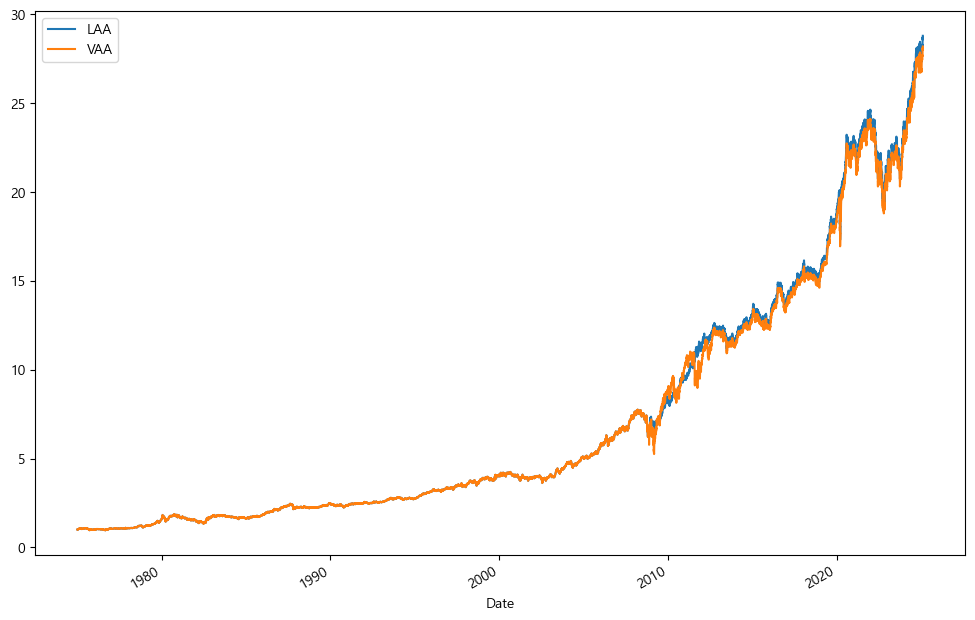

In [114]:
result.plot()

In [ ]:
# Stage에 따른 비중 설정
def set_ratios(stage):
    if stage == 'S1':
        return 0, 0.5, 0.25, 0.25
    elif stage == 'S2':
        return 0, 0.5, 0.25, 0.25
    elif stage == 'S3':
        return 1, 0, 0, 0
    else:
        return 0.7, 0, 0.15, 0.15

temp_df[['TQQQ_Ratio', 'QQQ_Ratio', 'TLT_Ratio', 'Gold_Ratio']] = temp_df['Stage'].apply(set_ratios).apply(pd.Series)

temp_df['Strategy'] = ((temp_df['TQQQ'].pct_change().fillna(0) * temp_df['TQQQ_Ratio'] + 
                        temp_df['QQQ'].pct_change().fillna(0) * temp_df['QQQ_Ratio'] + 
                        temp_df['TLT'].pct_change().fillna(0) * temp_df['TLT_Ratio'] + 
                        temp_df['Gold'].pct_change().fillna(0) * temp_df['Gold_Ratio'] )+1).cumprod()*100

<Axes: xlabel='Date'>

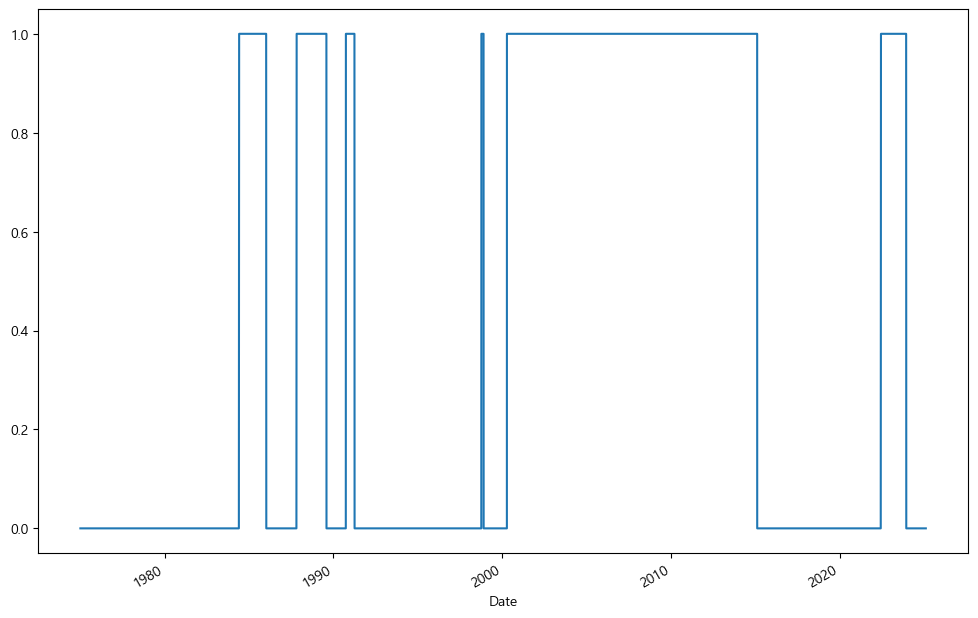

In [30]:
temp_df['Signal'].plot()

In [9]:


temp_df['Stage'] = 'S0'

s3_active = False
for i in temp_df.index:
    if temp_df.loc[i, 'Drawdown'] <= -.35:
        s3_active = True
    elif temp_df.loc[i, 'QQQ'] == temp_df.loc[i, 'QQQ_Peak']:
        s3_active = False

    if s3_active:
        temp_df.loc[i, 'Stage'] = 'S3'
    elif temp_df.loc[i, 'Drawdown'] <= -.25:
        temp_df.loc[i, 'Stage'] = 'S2'
    elif temp_df.loc[i, 'Drawdown'] <= -.15:
        temp_df.loc[i, 'Stage'] = 'S1'


temp_df['Stage'] = temp_df['Stage'].shift(0).fillna('S0')

,QQQ,TLT,IAU,Portfolio
Date,,,,
1975-01-02,100.000000,100.000000,100.000000,100.000000
1975-01-03,100.912250,100.076649,100.000000,100.342282
1975-01-06,101.790413,100.192096,99.850100,100.631808
1975-01-07,102.048753,100.192096,99.350195,100.547261
1975-01-08,101.377118,100.308118,101.347636,101.046099
...,...,...,...,...
2025-02-04,57207.974048,257.395593,1313.294858,3345.485798
2025-02-05,57467.579488,261.645252,1321.366934,3374.502448
2025-02-06,57767.543142,261.528820,1318.187017,3377.374302
